In [1]:
# Custom License
# 
# Copyright (c) 2024 Arya Vishal
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, and modify the Software, subject to the following conditions:
# 
# 1. No Selling: The Software may not be sold or sublicensed.
# 2. No Publishing: The Software may not be published or distributed without explicit written permission from the copyright holder.
# 
# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
# 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

import joblib

# Load the model from the file
model = joblib.load('random_forest_500_decision_tree.joblib')


In [2]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import os
import numpy as np
import rasterio

def load_dataset(data_dir, img_size=(256, 256)):
    """
    Load validation and test datasets from specified directory.

    Parameters:
    - data_dir (str): Directory containing val and test subdirectories.
    - img_size (tuple): Desired size of the image (height, width).

    Returns:
    - val_data (tuple): Tuple containing (X_val, y_val).
    - test_data (tuple): Tuple containing (X_test, y_test).
    """
    val_dir = os.path.join(data_dir, 'val')
    test_dir = os.path.join(data_dir, 'test')

    # Load validation data
    X_val, y_val = load_data_from_dir(os.path.join(val_dir, 'input'), os.path.join(val_dir, 'output'), img_size)
    # Load test data
    X_test, y_test = load_data_from_dir(os.path.join(test_dir, 'input'), os.path.join(test_dir, 'output'), img_size)

    # Preprocess to handle NaN values
    X_val = preprocess_data(X_val)
    X_test = preprocess_data(X_test)

    return (X_val, y_val), (X_test, y_test)

def preprocess_data(images):
    """
    Preprocesses input images to handle NaN values.

    Parameters:
    - images (numpy.ndarray): Array of input images.

    Returns:
    - images (numpy.ndarray): Processed array of input images.
    """
    # Replace NaN values with 0
    images[np.isnan(images)] = 0

    return images

def load_data_from_dir(input_dir, output_dir, img_size):
    """
    Load data (images and labels) from input and output directories.

    Parameters:
    - input_dir (str): Directory containing input images.
    - output_dir (str): Directory containing output images.
    - img_size (tuple): Desired size of the image (height, width).

    Returns:
    - images (numpy.ndarray): Array of loaded input images.
    - labels (numpy.ndarray): Array of corresponding output images.
    """
    images = []
    labels = []

    for filename in os.listdir(input_dir):
        if filename.endswith('.tif'):
            # Load input image (X)
            input_path = os.path.join(input_dir, filename)
            img = load_tiff_image(input_path, img_size)
            images.append(img)

            # Load corresponding output image (y)
            output_filename = filename.replace('.tif', '_cl.tif')
            output_path = os.path.join(output_dir, output_filename)
            label = load_tiff_image(output_path, img_size, is_label=True)
            label[np.isnan(label)] = 0 
            labels.append(label)

    if images and labels:
        images = np.array(images)
        labels = np.array(labels)

    return images, labels

def load_tiff_image(path, img_size, is_label=False):
    """
    Load a TIFF image from specified path.

    Parameters:
    - path (str): Path to the TIFF image.
    - img_size (tuple): Desired size of the image (height, width).
    - is_label (bool): Whether the image is a label image.

    Returns:
    - img (numpy.ndarray): Loaded image as a numpy array.
    """
    with rasterio.open(path) as src:
        img = src.read()

    # Reshape and resize if necessary
    img = img.transpose(1, 2, 0)  # Change from bands x height x width to height x width x bands
    img = img[:img_size[0], :img_size[1], :]  # Resize to desired size

    if is_label:
        # Convert label image to binary classification (1 for Marine Debris, 0 for others)
        img = (img == 1).astype(np.uint8)  # Assuming Marine Debris class is encoded as 1

    return img

# Example usage:
data_dir = 'MARIDA'
(X_val, y_val), (X_test, y_test) = load_dataset(data_dir)

print(f"Validation data: X_val shape = {X_val.shape}, y_val shape = {y_val.shape}")
print(f"Testing data: X_test shape = {X_test.shape}, y_test shape = {y_test.shape}")


Validation data: X_val shape = (328, 256, 256, 11), y_val shape = (328, 256, 256, 1)
Testing data: X_test shape = (359, 256, 256, 11), y_test shape = (359, 256, 256, 1)


In [4]:
test_x = np.reshape(X_test,(359*256*256,11))

In [5]:
test_y = np.reshape(y_test,(359*256*256,1))
test_y.shape

(23527424, 1)

In [6]:
import pandas as pd
Coastal = pd.DataFrame(test_x).iloc[:, 0]  # costel 
Blue = pd.DataFrame(test_x).iloc[:, 1] # blue 
Green = pd.DataFrame(test_x).iloc[:, 2] # green 
RED = pd.DataFrame(test_x).iloc[:, 3] #
RedEdge1 = pd.DataFrame(test_x).iloc[:, 4]
RedEdge2 = pd.DataFrame(test_x).iloc[:, 5]
RedEdge3 = pd.DataFrame(test_x).iloc[:, 6]
NIR = pd.DataFrame(test_x).iloc[:, 7]
Narrow_NIR = pd.DataFrame(test_x).iloc[:, 8]
SWIR1 = pd.DataFrame(test_x).iloc[:, 9]
SWIR2 = pd.DataFrame(test_x).iloc[:, 10]

# print(first_column.tolist())


In [7]:
NDVI = (NIR - RED) / (NIR + RED)
print(np.isinf(NDVI).sum())
print(np.isinf(NDVI).sum())

0
0


In [8]:
Plastic = NIR / (NIR - RED)
print(np.isinf(Plastic).sum())
print(np.isinf(-Plastic).sum())

0
0


In [9]:
FDI = NIR - (RedEdge2+ (SWIR1 - RedEdge2) * ((842 - 665)/(1610 - 665)) * 10  )
np.isinf(FDI).sum()
np.isinf(-FDI).sum()

0

In [10]:
WaterIndex = (Green-NIR)/ (Green+NIR)
np.isinf(WaterIndex).sum()
np.isinf(-WaterIndex).sum()

0

In [11]:
X_test = pd.concat([FDI,WaterIndex,Plastic,NDVI,SWIR1,NIR,RED],axis=1)
X_test.shape

(23527424, 7)

In [12]:
np.isinf(X_test).sum()

0    0
1    0
2    0
3    0
9    0
7    0
3    0
dtype: int64

In [13]:
# Assuming X_test is a numpy array or pandas DataFrame
predictions = model.predict(X_test)


In [14]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Evaluate model performance
accuracy = accuracy_score(test_y, predictions)
# print(f'Accuracy: {accuracy:.2f}')

In [15]:
report = classification_report(predictions, test_y)
report

'              precision    recall  f1-score   support\n\n           0       0.99      1.00      1.00  23407653\n           1       0.90      0.00      0.01    119771\n\n    accuracy                           0.99  23527424\n   macro avg       0.95      0.50      0.50  23527424\nweighted avg       0.99      0.99      0.99  23527424\n'

In [16]:
# Calculate confusion matrix
cm = confusion_matrix(test_y, predictions)
cm

array([[23407616,   119427],
       [      37,      344]])

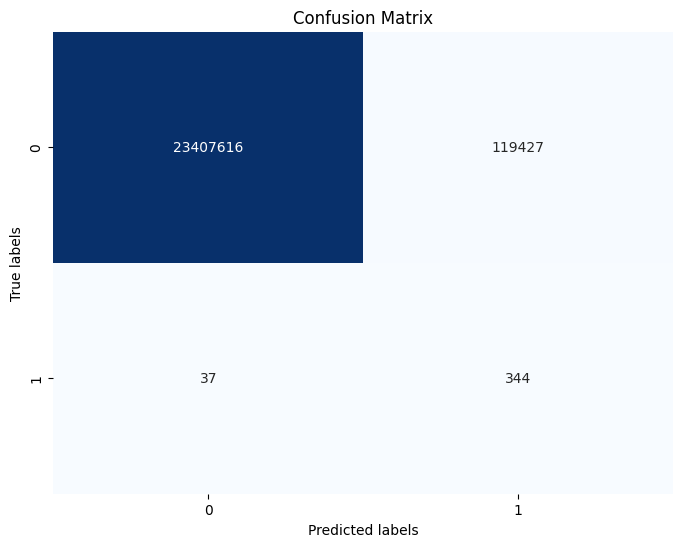

In [17]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [18]:
# Compute precision, recall, and F1-score
precision = precision_score(test_y, predictions)
recall = recall_score(test_y, predictions)
f1 = f1_score(test_y, predictions)



In [19]:
print("Confusion Matrix:")
# print(cm)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Confusion Matrix:
Precision: 0.00
Recall: 0.90
F1-score: 0.01


In [38]:
TP = 344
FN = 37
FP= 119427
# tn = 

In [39]:
iou_like = TP / (TP + FP + FN)

In [40]:
iou_like

0.002871260683760684

In [23]:
X_val.shape


(328, 256, 256, 11)

In [24]:
val_x = np.reshape(X_val,(328*256*256,11))
val_x.shape

(21495808, 11)

In [25]:
val_y = np.reshape(y_val,(328*256*256,1))
val_y.shape

(21495808, 1)

In [26]:
Coastal = pd.DataFrame(val_x).iloc[:, 0]  # costel 
Blue = pd.DataFrame(val_x).iloc[:, 1] # blue 
Green = pd.DataFrame(val_x).iloc[:, 2] # green 
RED = pd.DataFrame(val_x).iloc[:, 3] #
RedEdge1 = pd.DataFrame(val_x).iloc[:, 4]
RedEdge2 = pd.DataFrame(val_x).iloc[:, 5]
RedEdge3 = pd.DataFrame(val_x).iloc[:, 6]
NIR = pd.DataFrame(val_x).iloc[:, 7]
Narrow_NIR = pd.DataFrame(val_x).iloc[:, 8]
SWIR1 = pd.DataFrame(val_x).iloc[:, 9]
SWIR2 = pd.DataFrame(val_x).iloc[:, 10]

# print(first_column.tolist())


In [27]:
NDVI = (NIR - RED) / (NIR + RED)
print(np.isinf(NDVI).sum())
print(np.isinf(NDVI).sum())

0
0


In [28]:
Plastic = NIR / (NIR - RED)
print(np.isinf(Plastic).sum())
print(np.isinf(-Plastic).sum())

0
0


In [29]:
FDI = NIR - (RedEdge2+ (SWIR1 - RedEdge2) * ((842 - 665)/(1610 - 665)) * 10  )
np.isinf(FDI).sum()
np.isinf(-FDI).sum()

0

In [30]:
WaterIndex = (Green-NIR)/ (Green+NIR)
np.isinf(WaterIndex).sum()
np.isinf(-WaterIndex).sum()

0

In [31]:
X_val = pd.concat([FDI,WaterIndex,Plastic,NDVI,SWIR1,NIR,RED],axis=1)
X_val.shape

(21495808, 7)

In [32]:
np.isinf(X_val).sum()

0    0
1    0
2    0
3    0
9    0
7    0
3    0
dtype: int64

In [33]:
# Assuming X_test is a numpy array or pandas DataFrame
predictions = model.predict(X_val)


In [34]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Evaluate model performance
accuracy = accuracy_score(val_y, predictions)
# print(f'Accuracy: {accuracy:.2f}')

In [35]:
report = classification_report(predictions, val_y)
report

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00  21423749\n           1       0.92      0.01      0.03     72059\n\n    accuracy                           1.00  21495808\n   macro avg       0.96      0.51      0.51  21495808\nweighted avg       1.00      1.00      1.00  21495808\n'

In [41]:
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00  21423749
           1       0.92      0.01      0.03     72059

    accuracy                           1.00  21495808
   macro avg       0.96      0.51      0.51  21495808
weighted avg       1.00      1.00      1.00  21495808



In [36]:
# Calculate confusion matrix
cm = confusion_matrix(val_y, predictions)
cm

array([[21423662,    71071],
       [      87,      988]])

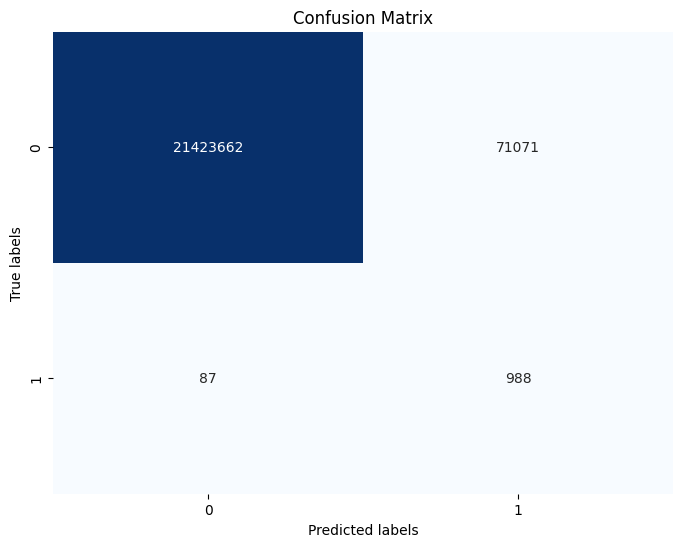

In [37]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [42]:
TP = 988
FN = 71071
FP= 87 
# tn = 

In [43]:
iou_like = TP / (TP + FP + FN)
iou_like